In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from pathlib import Path
import os
import nltk as nltk

from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pycaret as pc
from nltk.corpus import stopwords   # to get collection of stopwords
from sklearn.model_selection import train_test_split       # for splitting dataset
from tensorflow.keras.preprocessing.text import Tokenizer  # to encode text to int
from tensorflow.keras.preprocessing.sequence import pad_sequences   # to do padding or truncating
from tensorflow.keras.models import Sequential     # the model
from tensorflow.keras.layers import Embedding, LSTM, Dense # layers of the architecture
from tensorflow.keras.callbacks import ModelCheckpoint   # save model
from tensorflow.keras.models import load_model 
import seaborn as sns
from wordcloud import WordCloud,STOPWORDS
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import hvplot.pandas
import plotly.express as px
import datetime as dt
from pandas_profiling import ProfileReport
import seaborn  as sns
import spacy
import gensim
import plotly.graph_objects as go
import textblob   
import textstat
import pyLDAvis

from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from alpaca_trade_api.rest import TimeFrame
import warnings
warnings.filterwarnings('ignore')

C:\Users\BalleBalle\Anaconda3\envs\py37\lib\site-packages\sklearn\decomposition\_lda.py:28: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EPS = np.finfo(np.float).eps


In [2]:
!python -m spacy download en_core_web_sm 
!python -m textblob.download_corpora

  Using cached en_core_web_sm-2.3.1-py3-none-any.whl
[+] Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
Finished.


[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\BalleBalle\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\BalleBalle\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\BalleBalle\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\BalleBalle\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to
[nltk_data]     C:\Users\BalleBalle\AppData\Roaming\nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     C:\Users\BalleBalle\AppData\Roaming\nltk_data...
[nltk_data]   Package movie_

In [3]:
#Create a function to read files for the Ticker Symbol

def read_file(TKR): 
    """ # Function to read file and store the output of the file content into a dictionary
         :param filename - Ticker symbol of company. Assumption is that the filename is stored as TKR.csv

    """
    filename='../Data/'+TKR+'.csv'
    
    movie_reviews= pd.read_csv(filename,parse_dates=True,usecols=np.r_[3,9:11])
            
    return movie_reviews



In [4]:
#Read Netflix Data
movie_reviews_NFLX=read_file('netflix')
movie_reviews_NFLX.head()

critics_consensus original_release_date  \
0                                                NaN                   NaN   
1  Thanks to director Zak Hilditch's patient stor...            10/20/2017   
2  22 July offers a hard-hitting close-up look at...            10/10/2018   
3  37 Seconds is a rare and refreshing film that ...                   NaN   
4  Delicately sketched but thematically rich, 6 B...                   NaN   

  streaming_release_date  
0              5/19/2020  
1             10/20/2017  
2             10/10/2018  
3              1/31/2020  
4               4/6/2018

#### Use critics_consensus column to view any association between this column and Stock Price movement.

##### Data Profiling

In [5]:
from pandas_profiling import ProfileReport
profile = ProfileReport(movie_reviews_NFLX, title="Pandas Profiling Report", explorative=True)
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
#We will be using streaming_release_date for Time series association check and critics_consensus for NLP.
#From above it shows there are rows with missing values in those fields.
#We will remove those rows.
movie_reviews_NFLX = movie_reviews_NFLX[movie_reviews_NFLX['streaming_release_date'].notna()]
movie_reviews_NFLX = movie_reviews_NFLX[movie_reviews_NFLX['critics_consensus'].notna()]

[]

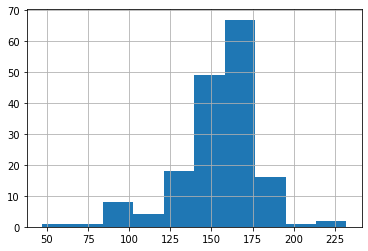

In [7]:
#Length of each comment
movie_reviews_NFLX['critics_consensus'].str.len().hist().plot(kind='bar')
#Graph shows that range is between 175 and 200 characters. So we should use modules which are effective for small document size.


In [8]:
#Number of words in each comment
movie_reviews_NFLX['critics_consensus'].str.split().str.len()


1      23
2      28
3      16
4      24
5      28
       ..
347    23
349    28
350    32
353    24
354    28
Name: critics_consensus, Length: 167, dtype: int64

In [9]:
#Convert Dates from object to datetime
movie_reviews_NFLX[["original_release_date", "streaming_release_date"]] = movie_reviews_NFLX[["original_release_date", "streaming_release_date"]].apply(pd.to_datetime)

##### We will use NLTK, GENSIM, SPACY and TEXTBLOB to do 
Date pre-processing and then check with word cloud the quality and difference in output.

In [10]:
nltk.download('stopwords')
stop=set(stopwords.words('english'))
# Remove Stop Words
movie_reviews_NFLX['critics_consensus_ntext']=movie_reviews_NFLX['critics_consensus'].apply(lambda words: ' '.join(word.lower() for word in words.split() if word not in stop))
movie_reviews_NFLX.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\BalleBalle\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


critics_consensus original_release_date  \
1  Thanks to director Zak Hilditch's patient stor...            2017-10-20   
2  22 July offers a hard-hitting close-up look at...            2018-10-10   
3  37 Seconds is a rare and refreshing film that ...                   NaT   
4  Delicately sketched but thematically rich, 6 B...                   NaT   
5  6 Underground is loud, frenetic, and finally p...            2019-12-13   

  streaming_release_date                            critics_consensus_ntext  
1             2017-10-20  thanks director zak hilditch's patient storyte...  
2             2018-10-10  22 july offers hard-hitting close-up look afte...  
3             2020-01-31  37 seconds rare refreshing film depicts disabi...  
4             2018-04-06  delicately sketched thematically rich, 6 ballo...  
5             2019-12-13  6 underground loud, frenetic, finally preposte...

In [11]:
#NLTK Lemmatization
#Create function to create POS tags to be used for lemmentization.
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
# Lemmatize with POS Tag
from nltk.corpus import wordnet
from collections import Counter
import re
nltk.download('averaged_perceptron_tagger')

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

# Complete the tokenizer function
def lemmatize_sentence(sentence):
    #tokenize the sentence and find the POS tag for each token
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))
    #tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x: (x[0], get_wordnet_pos(x[1])), nltk_tagged)
    lemmatizer = WordNetLemmatizer()
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            #if there is no available tag, append the token as is
            lemmatized_sentence.append(word)
        else:
            #else use the tag to lemmatize the token
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_sentence)



# Lemmatizing
# Create a new column after Lemmatization
movie_reviews_NFLX['critics_consensus_nltktext']=movie_reviews_NFLX['critics_consensus_ntext'].apply(lambda x: lemmatize_sentence(x))
movie_reviews_NFLX['critics_consensus_nltktext']=movie_reviews_NFLX['critics_consensus_nltktext'].apply(lambda words: ' '.join(word.lower() for word in words.split() if word not in stop))
#Replace word count with the new text
movie_reviews_NFLX['wnltkcount']=movie_reviews_NFLX['critics_consensus_nltktext'].str.split().str.len()
movie_reviews_NFLX['hnltklength']=movie_reviews_NFLX['critics_consensus_nltktext'].str.len()



[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\BalleBalle\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [12]:
#Lemmantization using Spacy
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
allowed_postags = ["NOUN", "ADJ", "VERB", "ADV","PROPN"]



# Lemmatizing
# Create a new column after Lemmatization
movie_reviews_NFLX['critics_consensus_spacytext'] = movie_reviews_NFLX['critics_consensus_ntext'].apply(lambda x: " ".join([y.lemma_ for y in nlp(x) if y.pos_ in allowed_postags]))
#Replace word count with the new headline text
movie_reviews_NFLX['wspacycount']=movie_reviews_NFLX['critics_consensus_spacytext'].str.split().str.len()
movie_reviews_NFLX['hspacylength']=movie_reviews_NFLX['critics_consensus_spacytext'].str.len()



In [13]:
#Lemmantization using Gensim
import pattern
from pattern.en import lemma, lexeme
from gensim.utils import lemmatize
movie_reviews_NFLX['critics_consensus_gensimtext']=movie_reviews_NFLX['critics_consensus_ntext'].apply(lambda x: lemmatize_sentence(x))
#Replace word count with the new headline text
movie_reviews_NFLX['wgensimcount']=movie_reviews_NFLX['critics_consensus_gensimtext'].str.split().str.len()
movie_reviews_NFLX['hgensimlength']=movie_reviews_NFLX['critics_consensus_gensimtext'].str.len()



In [14]:
#TextBlob Lemmatizer
from textblob import TextBlob
# Define function to lemmatize each word with its POS tag
def lemmatize_with_postag(sentence):
    sent = TextBlob(sentence)
    tag_dict = {"J": 'a', 
                "N": 'n', 
                "V": 'v', 
                "R": 'r'}
    words_and_tags = [(w, tag_dict.get(pos[0], 'n')) for w, pos in sent.tags]    
    lemmatized_list = [wd.lemmatize(tag) for wd, tag in words_and_tags]
    return " ".join(lemmatized_list)

# Lemmatize
movie_reviews_NFLX['critics_consensus_txtblbtext']=movie_reviews_NFLX['critics_consensus_ntext'].apply(lambda x: lemmatize_with_postag(x))
#Replace word count with the new headline text
movie_reviews_NFLX['wtxtblbcount']=movie_reviews_NFLX['critics_consensus_txtblbtext'].str.split().str.len()
movie_reviews_NFLX['htxtblblength']=movie_reviews_NFLX['critics_consensus_txtblbtext'].str.len()

movie_reviews_NFLX.head()

critics_consensus original_release_date  \
1  Thanks to director Zak Hilditch's patient stor...            2017-10-20   
2  22 July offers a hard-hitting close-up look at...            2018-10-10   
3  37 Seconds is a rare and refreshing film that ...                   NaT   
4  Delicately sketched but thematically rich, 6 B...                   NaT   
5  6 Underground is loud, frenetic, and finally p...            2019-12-13   

  streaming_release_date                            critics_consensus_ntext  \
1             2017-10-20  thanks director zak hilditch's patient storyte...   
2             2018-10-10  22 july offers hard-hitting close-up look afte...   
3             2020-01-31  37 seconds rare refreshing film depicts disabi...   
4             2018-04-06  delicately sketched thematically rich, 6 ballo...   
5             2019-12-13  6 underground loud, frenetic, finally preposte...   

                          critics_consensus_nltktext  wnltkcount  hnltklength  \
1  thanks director zak hilditch 's patient storyt...          21          136   
2  22 july offer hard-hitting close-up look after...          20          144   
3  37 second rare refreshing film depicts disabil...          13           78   
4  delicately sketched thematically rich , 6 ball...          21          148   
5  6 underground loud , frenetic , finally prepos...          22          134   

                         critics_consensus_spacytext  wspacycount  \
1  thank director zak hilditch patient storytelle...           16   
2  july offer hard hit close look aftereffect ter...           17   
3  second rare refreshing film depict disability ...            9   
4  delicately sketch thematically rich balloon ri...           17   
5  underground loud frenetic finally preposterous...           14   

   hspacylength                       critics_consensus_gensimtext  \
1           113  thanks director zak hilditch 's patient storyt...   
2           121  22 july offer hard-hitting close-up look after...   
3            68  37 second rare refreshing film depicts disabil...   
4           125  delicately sketched thematically rich , 6 ball...   
5           107  6 underground loud , frenetic , finally prepos...   

   wgensimcount  hgensimlength  \
1            21            136   
2            20            144   
3            13             78   
4            21            148   
5            22            134   

                        critics_consensus_txtblbtext  wtxtblbcount  \
1  thanks director zak hilditch 's patient storyt...            19   
2  22 july offer hard-hitting close-up look after...            18   
3  37 second rare refresh film depicts disability...            10   
4  delicately sketch thematically rich 6 balloon ...            18   
5  6 underground loud frenetic finally prepostero...            17   

   htxtblblength  
1            129  
2            135  
3             69  
4            139  
5            121

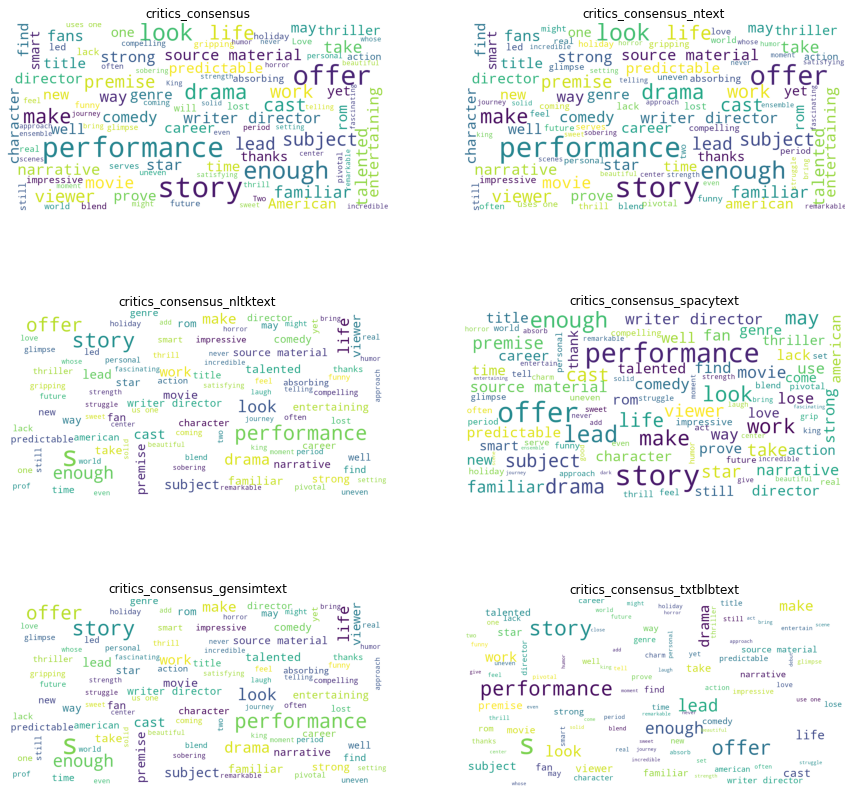

In [15]:
#Word clouds for each of the Lemmatizer

fig = plt.figure(1, figsize=(15, 15))
for i in range(len(movie_reviews_NFLX.columns[movie_reviews_NFLX.dtypes==object])):
    ax = fig.add_subplot( int(len(movie_reviews_NFLX.columns[movie_reviews_NFLX.dtypes==object])/2),2,i+1)
    
    column=movie_reviews_NFLX.columns[movie_reviews_NFLX.dtypes==object][i]
    
    words = ' '.join(movie_reviews_NFLX[column])
    
    wordcloud = WordCloud(
                      background_color='white', 
                      max_words=100,
                      max_font_size=30,
                      scale=3,
                      random_state=1
                     ).generate(words)
    ax.title.set_text(movie_reviews_NFLX.columns[movie_reviews_NFLX.dtypes==object][i])
    ax.imshow(wordcloud)
    ax.axis('off')

It seems like Spacy is performing the best as seen by big words.

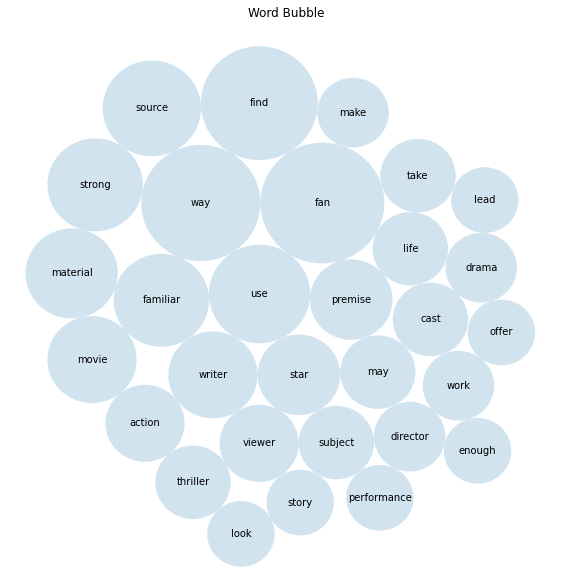

In [16]:
#Word Bubbles
#We will use SpacyText to see the word distribution in a form other than wordcloud to confirm and surprisingly 
# the output is totatly different.

import circlify

def df_create_bubble(document):
    
   
    word_counts = Counter()

    document.str.lower().str.split().apply(lambda x: [w.strip() for w in x if w.strip() not in stop]).apply(word_counts.update)

    
    # settings for treemap
    common_n = [n for (w, n) in word_counts.most_common(30)] # top30 words' counts
    common_w = [w for (w, n) in word_counts.most_common(30)] # top30 words
    keywords = pd.DataFrame(word_counts.most_common(30), columns = ['Words', 'Freq'])
    
    return keywords

df_bubble=df_create_bubble(movie_reviews_NFLX['critics_consensus_spacytext'])


# compute circle positions:
circles = circlify.circlify(
    df_bubble['Freq'].tolist(), 
    show_enclosure=False, 
    target_enclosure=circlify.Circle(x=0, y=0, r=1)
)



# Create just a figure and only one subplot
fig, ax = plt.subplots(figsize=(10,10))

# Title
ax.set_title('Word Bubble')

# Remove axes
ax.axis('off')

# Find axis boundaries
lim = max(
    max(
        abs(circle.x) + circle.r,
        abs(circle.y) + circle.r,
    )
    for circle in circles
)
plt.xlim(-lim, lim)
plt.ylim(-lim, lim)

# list of labels
labels = df_bubble['Words']

# print circles
for circle, label in zip(circles, labels):
    x, y, r = circle
    ax.add_patch(plt.Circle((x, y), r, alpha=0.2, linewidth=2))
    plt.annotate(
          label, 
          (x,y ) ,
          va='center',
          ha='center'
     )

#### Stock Data Extraction and Profiling

In [17]:
# Obtain Keys to connect to ALPACA API
load_dotenv() # True
CONSUMER_KEY = os.environ.get("ALPACA_API_KEY")

CONSUMER_SECRET_KEY = os.environ.get("ALPACA_SECRET_KEY")
#quandl.ApiConfig.api_key = os.environ.get("QUANTA_API_KEY")

In [18]:
# Initialize ALPACA API
ALPACA_URL='https://paper-api.alpaca.markets'
alpaca_api = tradeapi.REST(CONSUMER_KEY, CONSUMER_SECRET_KEY, ALPACA_URL, api_version='v2')

In [19]:
# Call ALPACA API to get data for ticker symbols.
# Format current date as ISO format
NY = 'America/New_York'

edate = dt.date.today()
start=pd.Timestamp('2010-01-01', tz=NY).isoformat()
end=pd.Timestamp(edate, tz=NY).isoformat()
# Set the tickers
tickers = ["NFLX"]
# Set timeframe to '1D' for Alpaca API, 
# Get current closing prices for SPY and Ticker 
# (use a limit=1000 parameter to call the most recent 1000 days of data)
alpaca_api.get_bars(tickers, '1D', start=start, end=end, limit=1000).df

open      high       low   close    volume  \
timestamp                                                                 
2015-12-01 05:00:00+00:00  124.48  125.5700  122.4200  125.37  12550755   
2015-12-02 05:00:00+00:00  125.53  131.3500  124.9300  128.93  24105712   
2015-12-03 05:00:00+00:00  129.74  132.2000  126.3900  126.81  26644540   
2015-12-04 05:00:00+00:00  127.01  130.9900  125.7500  130.93  20250411   
2015-12-07 05:00:00+00:00  131.65  133.2700  122.7500  125.36  23351531   
...                           ...       ...       ...     ...       ...   
2019-11-13 05:00:00+00:00  291.03  293.4100  281.1400  283.11   9233201   
2019-11-14 05:00:00+00:00  283.58  290.6300  283.2200  289.62   6554171   
2019-11-15 05:00:00+00:00  290.77  295.8186  287.5680  295.03   6387779   
2019-11-18 05:00:00+00:00  296.00  304.9900  293.2800  302.57   8621566   
2019-11-19 05:00:00+00:00  304.38  305.6699  298.5201  302.60   5919710   

                           trade_count        vwap symbol  
timestamp                                                  
2015-12-01 05:00:00+00:00        73017  124.400173   NFLX  
2015-12-02 05:00:00+00:00       143571  129.278581   NFLX  
2015-12-03 05:00:00+00:00       150577  128.988364   NFLX  
2015-12-04 05:00:00+00:00       113799  128.454281   NFLX  
2015-12-07 05:00:00+00:00       142911  127.261709   NFLX  
...                                ...         ...    ...  
2019-11-13 05:00:00+00:00       103071  286.219799   NFLX  
2019-11-14 05:00:00+00:00        78592  287.936363   NFLX  
2019-11-15 05:00:00+00:00        73415  293.642743   NFLX  
2019-11-18 05:00:00+00:00       107315  301.811011   NFLX  
2019-11-19 05:00:00+00:00        66588  302.349187   NFLX  

[1000 rows x 8 columns]

In [20]:
#Create dataframe to store API output
NFLX_DF=alpaca_api.get_bars(tickers, '1D', start=start, end=end, limit=1000).df
NFLX_DF.head()

open    high     low   close    volume  \
timestamp                                                             
2015-12-01 05:00:00+00:00  124.48  125.57  122.42  125.37  12550755   
2015-12-02 05:00:00+00:00  125.53  131.35  124.93  128.93  24105712   
2015-12-03 05:00:00+00:00  129.74  132.20  126.39  126.81  26644540   
2015-12-04 05:00:00+00:00  127.01  130.99  125.75  130.93  20250411   
2015-12-07 05:00:00+00:00  131.65  133.27  122.75  125.36  23351531   

                           trade_count        vwap symbol  
timestamp                                                  
2015-12-01 05:00:00+00:00        73017  124.400173   NFLX  
2015-12-02 05:00:00+00:00       143571  129.278581   NFLX  
2015-12-03 05:00:00+00:00       150577  128.988364   NFLX  
2015-12-04 05:00:00+00:00       113799  128.454281   NFLX  
2015-12-07 05:00:00+00:00       142911  127.261709   NFLX

In [21]:
NFLX_DF['Daily Return'] = NFLX_DF['close'].pct_change(1)
NFLX_DF.head()

open    high     low   close    volume  \
timestamp                                                             
2015-12-01 05:00:00+00:00  124.48  125.57  122.42  125.37  12550755   
2015-12-02 05:00:00+00:00  125.53  131.35  124.93  128.93  24105712   
2015-12-03 05:00:00+00:00  129.74  132.20  126.39  126.81  26644540   
2015-12-04 05:00:00+00:00  127.01  130.99  125.75  130.93  20250411   
2015-12-07 05:00:00+00:00  131.65  133.27  122.75  125.36  23351531   

                           trade_count        vwap symbol  Daily Return  
timestamp                                                                
2015-12-01 05:00:00+00:00        73017  124.400173   NFLX           NaN  
2015-12-02 05:00:00+00:00       143571  129.278581   NFLX      0.028396  
2015-12-03 05:00:00+00:00       150577  128.988364   NFLX     -0.016443  
2015-12-04 05:00:00+00:00       113799  128.454281   NFLX      0.032490  
2015-12-07 05:00:00+00:00       142911  127.261709   NFLX     -0.042542

<AxesSubplot:xlabel='timestamp'>

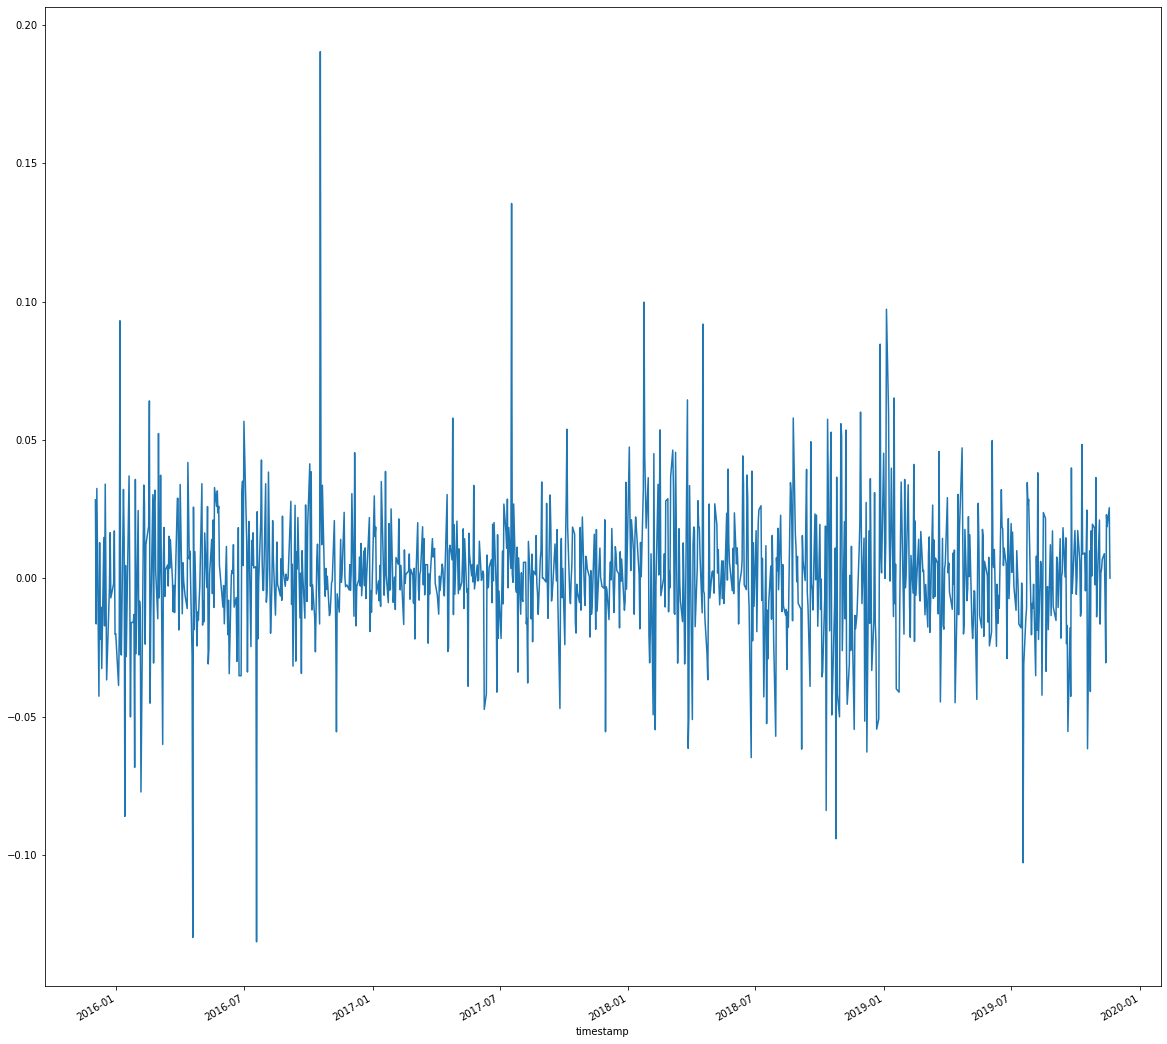

In [22]:
# Plot daily returns 
NFLX_DF['Daily Return'].plot(figsize=(20, 20))

<AxesSubplot:xlabel='timestamp'>

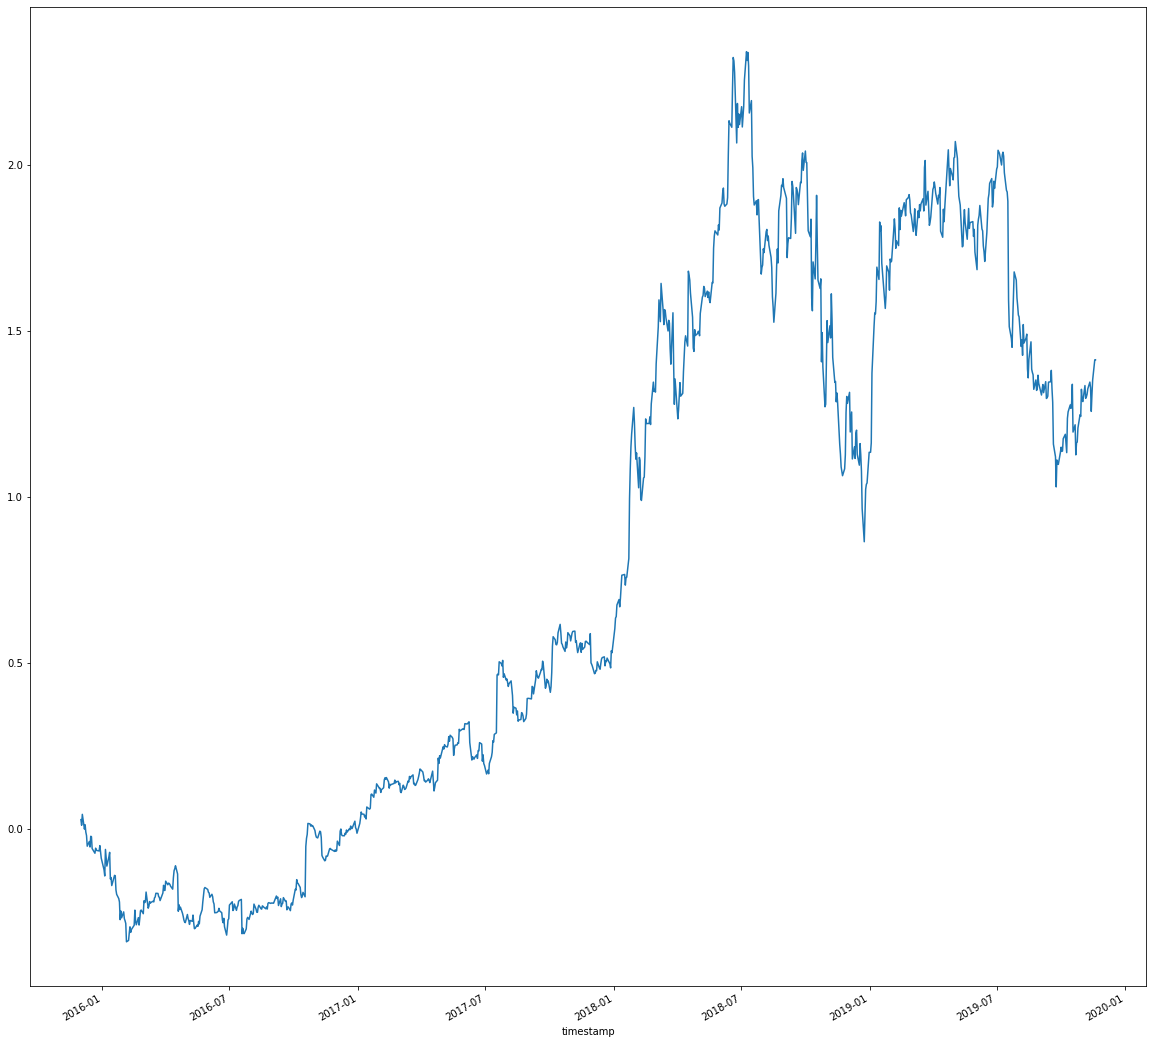

In [23]:
# Calculate cumulative returns 

# Plot cumulative returns
((NFLX_DF['Daily Return'] + 1).cumprod() - 1).plot(figsize=(20, 20))

<AxesSubplot:xlabel='timestamp'>

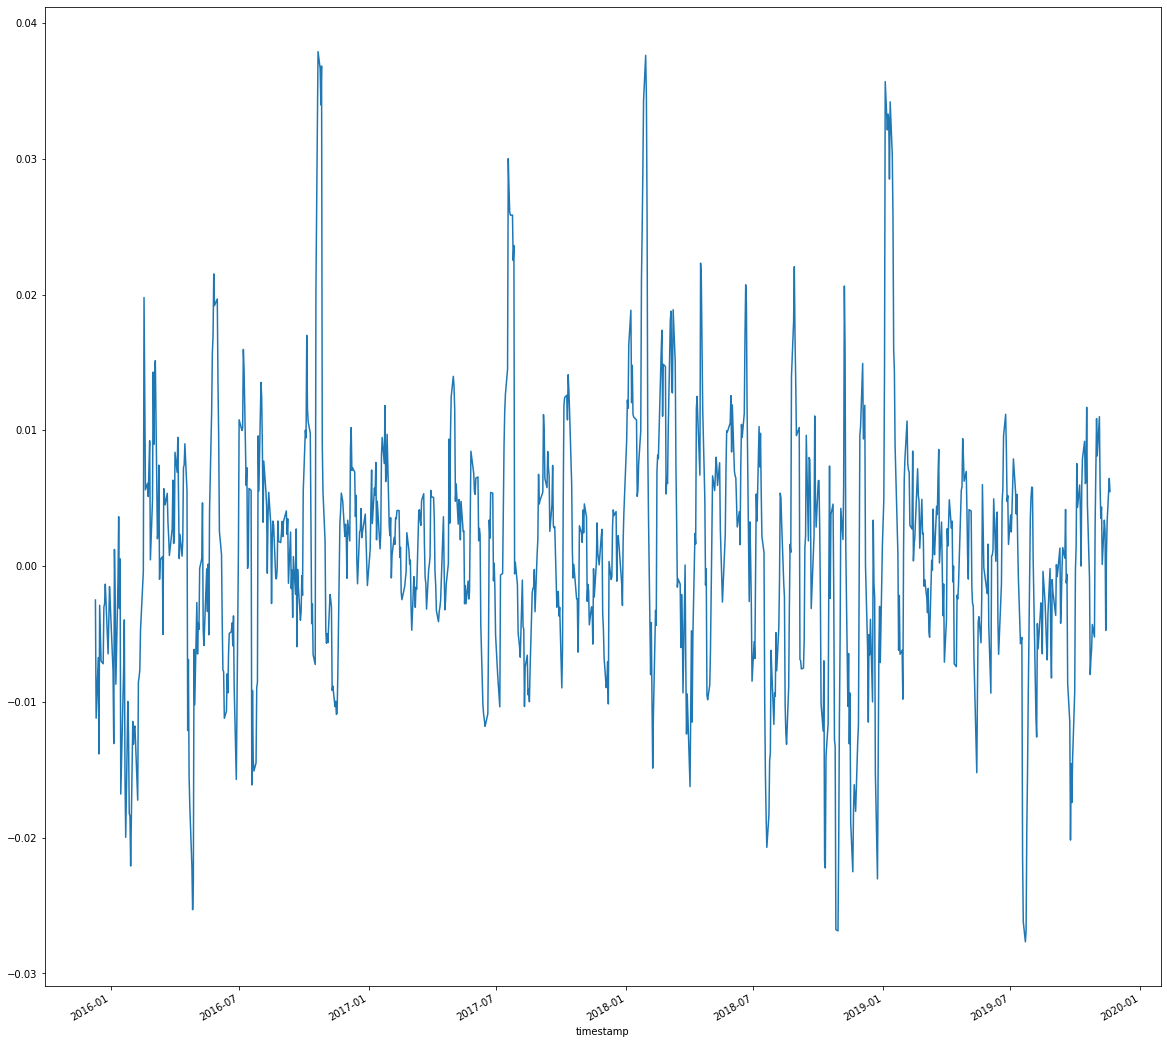

In [24]:
# Plot a rolling 7-day mean of NFLX's Daily Return
NFLX_DF['Daily Return'].rolling(window = 7).mean().plot(figsize=(20, 20))

##### Back to NLP, we will generate Sentiment polarity score using a new library FLAIR

flair’s sentiment classifier is based on a character-level LSTM neural network which takes sequences of letters 
and words into account when predicting. It’s based on a corpus but in the meantime, it could also predict a sentiment
for OOV(Out of Vocab) words including typos.

In [25]:
import flair
sentiment_model = flair.models.TextClassifier.load('en-sentiment')

2022-05-06 13:10:26,137 loading file C:\Users\BalleBalle\.flair\models\sentiment-en-mix-distillbert_4.pt


In [26]:
# we will append probability and sentiment preds later
probs = []
sentiments = []

for comment in movie_reviews_NFLX['critics_consensus_spacytext'].to_list():
    # make prediction
    sentence = flair.data.Sentence(comment)
    sentiment_model.predict(sentence)
    # extract sentiment prediction
    probs.append(sentence.labels[0].score)  # numerical score 0-1
    sentiments.append(sentence.labels[0].value)  # 'POSITIVE' or 'NEGATIVE'

# add probability and sentiment predictions to tweets dataframe
movie_reviews_NFLX['Flair_Score_draft'] = probs
movie_reviews_NFLX['sentiment_flair'] = sentiments

In [27]:
# Convert the Flair score to show the sign of the value.
movie_reviews_NFLX['Flair_Score']= movie_reviews_NFLX['sentiment_flair'].apply(lambda x: '-' if (x == 'NEGATIVE') else '') 

movie_reviews_NFLX['Flair_Score'] = movie_reviews_NFLX['Flair_Score'] + movie_reviews_NFLX['Flair_Score_draft'].astype(str)
movie_reviews_NFLX['Flair_Score'] = pd.to_numeric(movie_reviews_NFLX['Flair_Score'], errors='coerce')

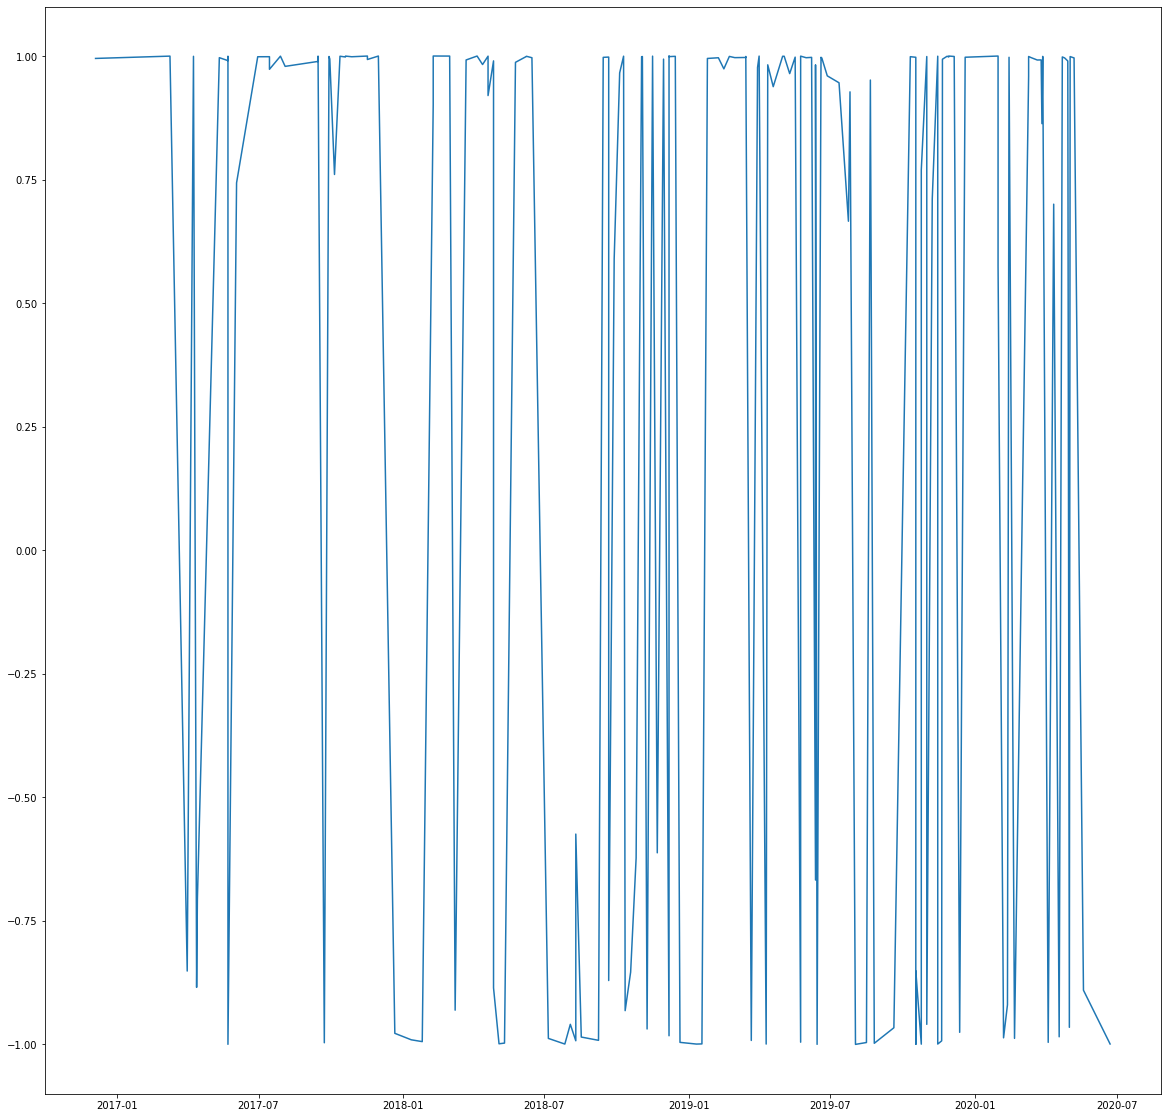

In [28]:
# Plot spacy cleaned critic_consensus score with time
#movie_reviews_NFLX['probabilityS-spacy'] .plot(figsize=(20, 20))
movie_reviews_NFLX = movie_reviews_NFLX.sort_values('streaming_release_date', ascending=True)
plt.rcParams["figure.figsize"] = (20,20)
plt.plot(movie_reviews_NFLX['streaming_release_date'], movie_reviews_NFLX['Flair_Score'])

In [29]:
#Compare with VADER
import nltk as nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
sentiments_netflix = []#creates empty list

#Going to use VADER’s SentimentIntensityAnalyzer() to see how many 'Neutral (neu)' , 'Positive (pos)', and 'Negatvie(neg)'
# words there are for each article. 
for articles in movie_reviews_NFLX['critics_consensus_spacytext']: #goes through each artilce in df and applies polarity
    try:
        text = articles #accessing each articles 'content' which contains the article itself in 'bitcoin_news'
        results = analyzer.polarity_scores(text) #this is how get compound, pos, neg, and nue polarity scores
        #during imports we set analyzer equal to SentimentIntensityAnalyzer() 
        #'results' uses this function to find polarity score for each article in bitcoin_news
        compound = results["compound"] #gets compound polarity score
        pos = results["pos"] #gets postive polarity score
        neu = results["neu"] #gets neutral polarity score
        neg = results["neg"] #gets negative polarity score

        sentiments_netflix.append({
            "text": text,
            "NLTK_Compound": compound,
            "Positive": pos,
            "Negative": neg,
            "Neutral": neu,
        }) #appends a dictionary inside the list-(sentiments) so a dataframe can be created
        #this appends all polarity score we got above
    except AttributeError:
        pass
#rinse and repeat for each article    
netflix = pd.DataFrame(sentiments_netflix)#creates a dataframe using the list of dicts
#netflix = netflix.join(netflix_df['movie_title'])
#netflix = netflix.join(netflix_df['original_release_date'])
#netflix = netflix.join(netflix_df['streaming_release_date'])
movie_reviews_NFLX=movie_reviews_NFLX.join(netflix['NLTK_Compound'])
#netflix = netflix.drop(columns = ['Positive', 'Negative', 'Neutral'])

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\BalleBalle\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [30]:
movie_reviews_NFLX.head()

critics_consensus original_release_date  \
347  What Happened, Miss Simone? is a compelling --...            2015-06-24   
54   Burning Sands covers familiar territory, but T...            2017-03-10   
270  The Discovery looks fascinating on paper, but ...                   NaT   
136  Into the Inferno finds director Werner Herzog ...            2016-10-28   
131  iBoy's original premise and Maisie Williams' s...            2017-01-27   

    streaming_release_date                            critics_consensus_ntext  \
347             2016-12-05  what happened, miss simone? compelling -- albe...   
54              2017-03-10  burning sands covers familiar territory, trevo...   
270             2017-04-01  the discovery looks fascinating paper, spite t...   
136             2017-04-09  into inferno finds director werner herzog obse...   
131             2017-04-13  iboy's original premise maisie williams' stron...   

                            critics_consensus_nltktext  wnltkcount  \
347  happened , miss simone ? compelling -- albeit ...          21   
54   burning sand cover familiar territory , trevor...          21   
270  discovery look fascinating paper , spite thoug...          16   
136  inferno find director werner herzog observing ...          18   
131  iboy 's original premise maisie williams ' str...          21   

     hnltklength                        critics_consensus_spacytext  \
347          143  happen miss simone compelling necessarily inco...   
54           152  burn sand cover familiar territory trevor jack...   
270          124  discovery look fascinating paper spite thought...   
136          129  inferno find director werner herzog observe be...   
131          145  iboy original premise maisie williams strong p...   

     wspacycount  hspacylength  \
347           13           110   
54            20           141   
270           14           116   
136           15           116   
131           17           134   

                          critics_consensus_gensimtext  wgensimcount  \
347  what happened , miss simone ? compelling -- al...            22   
54   burning sand cover familiar territory , trevor...            21   
270  the discovery look fascinating paper , spite t...            17   
136  into inferno find director werner herzog obser...            19   
131  iboy 's original premise maisie williams ' str...            21   

     hgensimlength                       critics_consensus_txtblbtext  \
347            148  what happen miss simone compelling albeit nece...   
54             152  burn sand cover familiar territory trevor jack...   
270            128  the discovery look fascinating paper spite tho...   
136            134  into inferno find director werner herzog obser...   
131            145  iboy 's original premise maisie williams ' str...   

     wtxtblbcount  htxtblblength  Flair_Score_draft sentiment_flair  \
347            17            132           0.995066        POSITIVE   
54             19            145           0.999739        POSITIVE   
270            14            122           0.851544        NEGATIVE   
136            16            121           0.999349        POSITIVE   
131            18            139           0.884558        NEGATIVE   

     Flair_Score  NLTK_Compound  
347     0.995066            NaN  
54      0.999739         0.7096  
270    -0.851544            NaN  
136     0.999349         0.4404  
131    -0.884558         0.9325

In [31]:
#Check TextBlob Sentiment score too
#movie_reviews_NFLX['score_txtblob'] = movie_reviews_NFLX['critics_consensus_spacytext'].apply(lambda Text: TextBlob(Text).sentiment)
movie_reviews_NFLX[['score_txtblob','subj_txtblob']] = movie_reviews_NFLX['critics_consensus_spacytext'].apply(lambda Text: pd.Series(TextBlob(Text).sentiment))

In [32]:
movie_reviews_NFLX.head()

critics_consensus original_release_date  \
347  What Happened, Miss Simone? is a compelling --...            2015-06-24   
54   Burning Sands covers familiar territory, but T...            2017-03-10   
270  The Discovery looks fascinating on paper, but ...                   NaT   
136  Into the Inferno finds director Werner Herzog ...            2016-10-28   
131  iBoy's original premise and Maisie Williams' s...            2017-01-27   

    streaming_release_date                            critics_consensus_ntext  \
347             2016-12-05  what happened, miss simone? compelling -- albe...   
54              2017-03-10  burning sands covers familiar territory, trevo...   
270             2017-04-01  the discovery looks fascinating paper, spite t...   
136             2017-04-09  into inferno finds director werner herzog obse...   
131             2017-04-13  iboy's original premise maisie williams' stron...   

                            critics_consensus_nltktext  wnltkcount  \
347  happened , miss simone ? compelling -- albeit ...          21   
54   burning sand cover familiar territory , trevor...          21   
270  discovery look fascinating paper , spite thoug...          16   
136  inferno find director werner herzog observing ...          18   
131  iboy 's original premise maisie williams ' str...          21   

     hnltklength                        critics_consensus_spacytext  \
347          143  happen miss simone compelling necessarily inco...   
54           152  burn sand cover familiar territory trevor jack...   
270          124  discovery look fascinating paper spite thought...   
136          129  inferno find director werner herzog observe be...   
131          145  iboy original premise maisie williams strong p...   

     wspacycount  hspacylength  ... hgensimlength  \
347           13           110  ...           148   
54            20           141  ...           152   
270           14           116  ...           128   
136           15           116  ...           134   
131           17           134  ...           145   

                          critics_consensus_txtblbtext  wtxtblbcount  \
347  what happen miss simone compelling albeit nece...            17   
54   burn sand cover familiar territory trevor jack...            19   
270  the discovery look fascinating paper spite tho...            14   
136  into inferno find director werner herzog obser...            16   
131  iboy 's original premise maisie williams ' str...            18   

    htxtblblength  Flair_Score_draft  sentiment_flair  Flair_Score  \
347           132           0.995066         POSITIVE     0.995066   
54            145           0.999739         POSITIVE     0.999739   
270           122           0.851544         NEGATIVE    -0.851544   
136           121           0.999349         POSITIVE     0.999349   
131           139           0.884558         NEGATIVE    -0.884558   

    NLTK_Compound  score_txtblob  subj_txtblob  
347           NaN       0.144444      0.697222  
54         0.7096       0.375000      0.500000  
270           NaN       0.033333      0.850000  
136        0.4404       0.475000      0.700000  
131        0.9325       0.095000      0.530000  

[5 rows x 22 columns]

In [33]:
movie_reviews_NFLX.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 167 entries, 347 to 188
Data columns (total 22 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   critics_consensus             167 non-null    object        
 1   original_release_date         90 non-null     datetime64[ns]
 2   streaming_release_date        167 non-null    datetime64[ns]
 3   critics_consensus_ntext       167 non-null    object        
 4   critics_consensus_nltktext    167 non-null    object        
 5   wnltkcount                    167 non-null    int64         
 6   hnltklength                   167 non-null    int64         
 7   critics_consensus_spacytext   167 non-null    object        
 8   wspacycount                   167 non-null    int64         
 9   hspacylength                  167 non-null    int64         
 10  critics_consensus_gensimtext  167 non-null    object        
 11  wgensimcount                  

#### Granger Causality test
The Granger Causality test is used to determine whether or not one time series is useful for forecasting another.
This test uses the following null and alternative hypotheses:
Null Hypothesis (H0): Time series x does not Granger-cause time series y
Alternative Hypothesis (HA): Time series x Granger-causes time series y
The term “Granger-causes” means that knowing the value of time series x at a certain lag is useful for 
predicting the value of time series y at a later time period.
Source: https://www.statology.org/granger-causality-test-in-python/
        
A prerequisite for performing the Granger Causality test is that the data need to be stationary i.e 
it should have a constant mean, constant variance, and no seasonal component. Transform the non-stationary 
data to stationary data by differencing it, either first-order or second-order differencing. 

There are number of tests available to validate Time series stationary characterstics,

Augmented Dickey Fuller test (ADH Test)
Kwiatkowski-Phillips-Schmidt-Shin – KPSS test (trend stationary)
Philips Perron test (PP Test)

The most commonly used is the ADF test, where the null hypothesis is the time series possesses a unit root and is non-stationary. So, if the P-Value in ADH test is less than the significance level (0.05), you reject the null hypothesis.

In [35]:
#We will use ADH Test on Netflix daily returns 
NFLX_DF = NFLX_DF[NFLX_DF['Daily Return'].notna()]
# Daily Returns
from statsmodels.tsa.stattools import adfuller


# ADF Test
result = adfuller(NFLX_DF['Daily Return'].values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')
    


ADF Statistic: -14.797469018373757
p-value: 2.124656134664051e-27
Critial Values:
   1%, -3.43694584277544
Critial Values:
   5%, -2.8644520725172873
Critial Values:
   10%, -2.5683205291305176


Based upon the significance level of 0.05 and the p-value of ADF test, the null hypothesis can be rejected.
Hence, the series is stationary.

In [36]:
#Since the series is stationaru, we will now apply the Granger Causality test.
#### Data Preprocessing for test
#1. Form both data sets matching the same dates
#2. Merge the resulting data frames on date.

# Netflix critic comment data pre-processing
# We will use Flair score 
nflx_mov_df=movie_reviews_NFLX[['streaming_release_date','Flair_Score']]

# Netflix daily return pre-processing
NFLX_DF.reset_index(inplace=True)
nflx_stk_df=NFLX_DF[['timestamp','Daily Return']]
nflx_stk_df['date']=nflx_stk_df['timestamp'].dt.date
#Convert Dates from object to datetime
nflx_stk_df[["date"]] = nflx_stk_df[["date"]].apply(pd.to_datetime)
nflx_stk_df.drop('timestamp', axis=1, inplace=True) 
nflx_stk_df = nflx_stk_df[['date', 'Daily Return']]

In [37]:
display(nflx_mov_df)

display(nflx_stk_df)

streaming_release_date  Flair_Score
347             2016-12-05     0.995066
54              2017-03-10     0.999739
270             2017-04-01    -0.851544
136             2017-04-09     0.999349
131             2017-04-13    -0.884558
..                     ...          ...
73              2020-05-01    -0.965433
276             2020-05-02     0.998806
41              2020-05-07     0.996058
324             2020-05-19    -0.890345
188             2020-06-22    -0.999138

[167 rows x 2 columns]

date  Daily Return
0   2015-12-02      0.028396
1   2015-12-03     -0.016443
2   2015-12-04      0.032490
3   2015-12-07     -0.042542
4   2015-12-08      0.012923
..         ...           ...
994 2019-11-13     -0.030478
995 2019-11-14      0.022995
996 2019-11-15      0.018680
997 2019-11-18      0.025557
998 2019-11-19      0.000099

[999 rows x 2 columns]

In [38]:
# Join the two dataframes
Final_df = pd.merge(nflx_mov_df, nflx_stk_df, how="inner", left_on="streaming_release_date", right_on="date").drop(["date"], axis=1)
Final_df.set_index('streaming_release_date',inplace=True)

In [39]:
Final_df.shape

(118, 2)

<AxesSubplot:xlabel='streaming_release_date'>

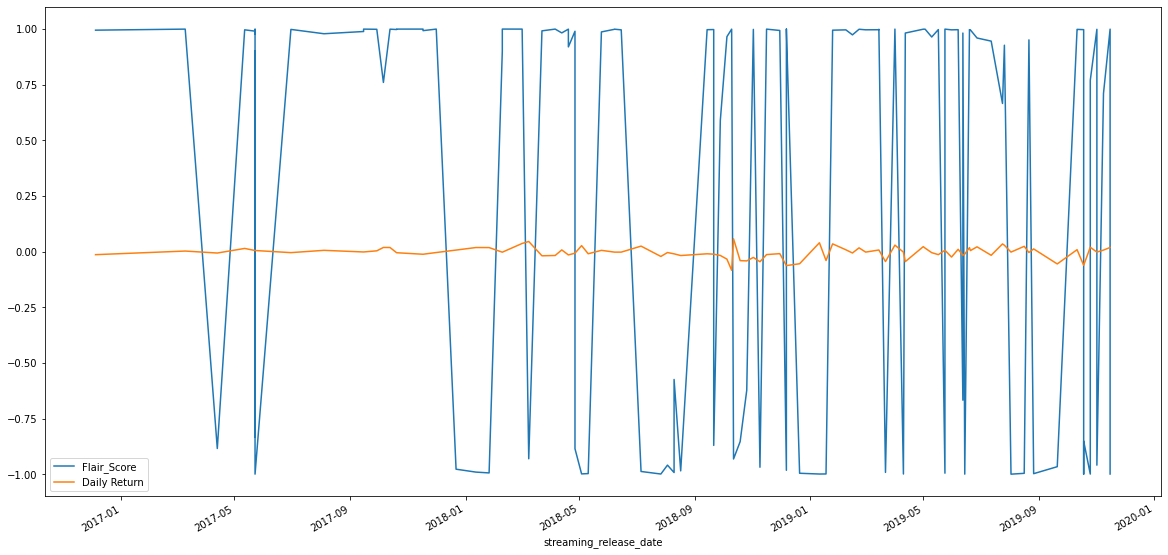

In [40]:
#Plot both columns against Release Date
Final_df.plot(figsize=(20, 10))

### Apply the Granger Casuality test



It accepts a 2D array with 2 columns as the main argument. The values are in the first column and the predictor (X)
is in the second column.

The Null hypothesis is: the series in the second column, does not Granger cause the series in the first. If the 
P-Values are less than a significance level (0.05) then you reject the null hypothesis and conclude that the said 
lag of X is indeed useful.

The second argument maxlag says till how many lags of Y should be included in the test.




In [41]:
from statsmodels.tsa.stattools import grangercausalitytests
#perform Granger-Causality test
grangercausalitytests(Final_df[['Daily Return', 'Flair_Score']], maxlag=[7])


Granger Causality
number of lags (no zero) 7
ssr based F test:         F=0.6781  , p=0.6902  , df_denom=96, df_num=7
ssr based chi2 test:   chi2=5.4883  , p=0.6006  , df=7
likelihood ratio test: chi2=5.3569  , p=0.6165  , df=7
parameter F test:         F=0.6781  , p=0.6902  , df_denom=96, df_num=7


{7: ({'ssr_ftest': (0.6780925818491309, 0.6901638300210842, 96.0, 7),
   'ssr_chi2test': (5.4883118343414035, 0.6005940573733648, 7),
   'lrtest': (5.356942035443581, 0.6164906521506949, 7),
   'params_ftest': (0.6780925818491326, 0.6901638300210812, 96.0, 7.0)},
   array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]])])}

#### Conclusion
In the above case P-Value is indeed above 0.05 and hence we can assume that the critic comments do not impact stock value.

We should further test with different publishing company and much bigger dataset.